In [5]:
#set the base path of the EW_Model folder
base_path = r'C:\Users\Utente\OneDrive - Princeton University\codes'

In [6]:
import os
import time; start_time = time.time()
import importlib as imp
import pyEW
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import warnings
#warnings.filterwarnings("ignore")
import pandas as pd
import json
# Set Arial as the default font family
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})

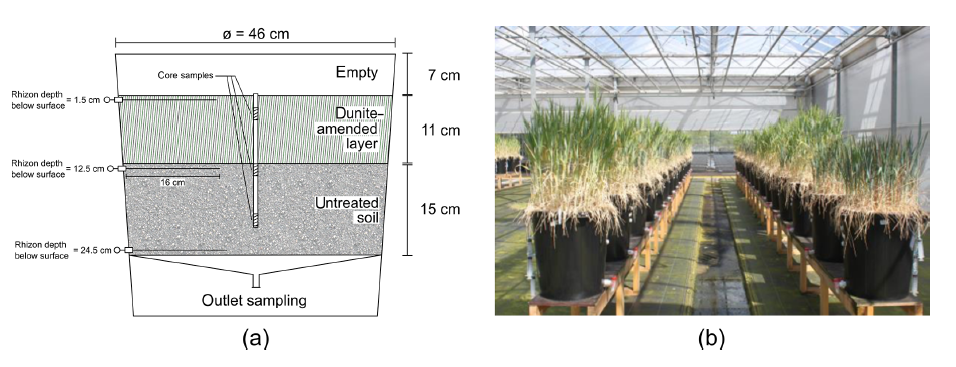

In [7]:
#experimental data
file_path = os.path.join(base_path, 'SMEW', 'Exp_Data', 'Amann_Biogeosci_2020', 'L_vs_t.json')
with open(file_path, 'r') as json_file:
    data_exp_L = json.load(json_file)

file_path = os.path.join(base_path, 'SMEW', 'Exp_Data', 'Amann_Biogeosci_2020', 'psd.json')
with open(file_path, 'r') as json_file:
    data_exp_psd = json.load(json_file)
    
file_path = os.path.join(base_path, 'SMEW', 'Exp_Data', 'Amann_Biogeosci_2020', 'Mg_flux_vs_t.json')
with open(file_path, 'r') as json_file:
    data_exp_Mg_flux = json.load(json_file)
    
file_path = os.path.join(base_path, 'SMEW', 'Exp_Data', 'Amann_Biogeosci_2020', 'pH_vs_t.json')
with open(file_path, 'r') as json_file:
    data_exp_pH = json.load(json_file)
    
file_path = os.path.join(base_path, 'SMEW', 'Exp_Data', 'Amann_Biogeosci_2020', 'pH_surf_vs_t.json')
with open(file_path, 'r') as json_file:
    data_exp_pH_surf = json.load(json_file)
    
file_path = os.path.join(base_path, 'SMEW', 'Exp_Data', 'Amann_Biogeosci_2020', 'pH_deep_vs_t.json')
with open(file_path, 'r') as json_file:
    data_exp_pH_deep = json.load(json_file)
    
file_path = os.path.join(base_path, 'SMEW', 'Exp_Data', 'Amann_Biogeosci_2020', 'Si_vs_t.json')
with open(file_path, 'r') as json_file:
    data_exp_Si = json.load(json_file)
    
data_pCO2 = {'name': ['ol_nocrop_w','untr_nocrop_w', 'ol_w', 'untr_w', 'ol_nocrop_s','untr_nocrop_s', 'ol_s', 'untr_s'],
    '5cm_avg': [800, 900, 1200, 1800, 1200, 1000, 900, 1500], # [microatm]
    '5cm_sigma': [1900,2100,3400,3600,np.nan,np.nan,2200,np.nan],
    '5cm_minus_sigma': [50, 100, 800, 100, np.nan, np.nan, 200, np.nan],
    '10cm_avg': [1200,1300,1900,1900,np.nan,2200,1900,2000], # [microatm]
    '10cm_sigma': [np.nan, 3000, 4000, 4200, np.nan, np.nan, 4400, 4400],
    '10cm_minus_sigma': [np.nan, 100, 100, 300, np.nan, np.nan, 200, 150],
    '20cm_avg': [1400, 1600, 2500, 2200, np.nan, 4200, 3400, 3400], # [microatm]
    '20cm_sigma': [np.nan, 3900, 5500, 5000, np.nan, 4200, 7900, np.nan],
    '20cm_minus_sigma': [np.nan, 500, 200, 200, np.nan, np.nan, 900, np.nan]}

In [8]:
# time 
t_end = 350 # [d]: number of simulated days
dt = 1/(24*6) # [time resolution (d)]
t=np.arange(0,t_end,dt)

#units
conv_mol = 1e6 # Conversion from moles to micromols 
conv_Al = 1e3 # Conversion for Al species from mols to nanomols

#water balance
keyword_wb = 1 # 1 = varying soil moisture. 0 = constant soil moisture

#background inputs of cations and anions
keyword_add = 1 # 1 = balance background losses. 0 = no addition

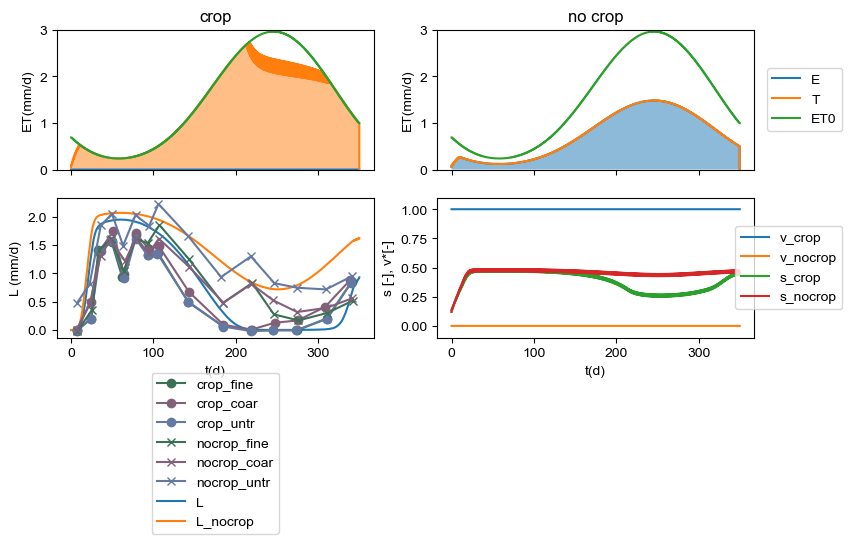

In [13]:
# HYDROCLIMATE AND WATER BALANCE

#soil 
soil = "loamy sand" #sand, loamy sand, sandy loam, loam
Zr = 0.26 # [m]: soil depth
rho_bulk = 1.15*1e6 #soil dry mass (g/m3)
s_in = 0.12 

#hydroclimatic
day1 = 300 #initial day for the simulation
latitude = 50*np.pi/180 # [radians]
albedo = 0.25
altitude = 10 #[m]
wind = 1*np.ones(len(t)) #[m/s]
coastal = False 
temp_av = 15 # [°C] yearly average
temp_ampl_yr= 9 # [°C] yearly amplitude
temp_ampl_d= 5 # [°C] daily amplitude

#temp [Celsius]
[temp_air,temp_soil,temp_min,temp_max] = pyEW.temp(latitude,temp_av, temp_ampl_yr, temp_ampl_d, Zr,t_end,dt,day1)

#ET0 [m/d]
ET0 = pyEW.ET0(latitude,altitude,temp_air,temp_soil,temp_min,temp_max, wind,albedo,Zr,coastal,t_end,dt,day1)

#deterministic rain [m]
Rain_yr = 0.8 # [m]: yearly rain
t_rain = 1 #[d]: between rain event
rain = np.zeros(len(t))
j = 1
while j < len(rain):
    rain[j] = Rain_yr/(365/t_rain)
    j = j+int(t_rain/dt)
del j

#CROP
T_v = 90 # [d] growth time
k_v = 500 # [g/m2] carrying capacity
RAI = 10 #[m2/m2] root area index
root_d = 0.4*1e-3 #[m] average root diameter
v_in = k_v # [g/m2] ic
t0_v = 0 # [d] starting day of growth
v = pyEW.veg(v_in, T_v, k_v, t0_v, temp_soil, dt)
[s, s_w, s_i, I, L, T, E, Q, Irr, n] = pyEW.moisture_balance(rain, Zr, soil, ET0, v, k_v, keyword_wb, s_in,t_end,dt)

#NO CROP
v_in = 0 # [g/m2] 
v_nocrop = pyEW.veg(v_in, T_v, k_v, t0_v, temp_soil, dt)
[s_nocrop, s_w, s_i, I, L_nocrop, T_nocrop, E_nocrop, Q_nocrop, Irr, n] = pyEW.moisture_balance(rain, Zr, soil, ET0, v_nocrop, k_v, keyword_wb, s_in,t_end,dt)


#Figure
fig, axs = plt.subplots(2,2,figsize=(9, 4))

axs[0,0].plot(t,E*1000, label ='E')
axs[0,0].plot(t,(E+T)*1000, label ='T')
axs[0,0].plot(t,1000*ET0, label ='ET0')
axs[0,0].set_xticklabels([])
axs[0,0].set_ylabel('ET(mm/d)')
axs[0,0].set_title('crop')
axs[0,0].set_ylim(0,3)
axs[0,0].fill_between(t,E*1000, 0,alpha=0.5)
axs[0,0].fill_between(t,(E+T)*1000,E*1000,alpha=0.5)

axs[0,1].plot(t,E_nocrop*1000, label ='E')
axs[0,1].plot(t,(E_nocrop+T_nocrop)*1000, label ='T')
axs[0,1].plot(t,1000*ET0, label ='ET0')
axs[0,1].set_xticklabels([])
axs[0,1].set_ylabel('ET(mm/d)')
axs[0,1].set_title('no crop')
axs[0,1].fill_between(t,E_nocrop*1000, 0,alpha=0.5)
axs[0,1].fill_between(t,(E_nocrop+T_nocrop)*1000,E_nocrop*1000,alpha=0.5)
axs[0,1].set_ylim(0,3)
axs[0,1].legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

all_x_values_L = []
all_y_values_L = []
series_names_L = []
series_colors_L = []
for dataset in data_exp_L['datasetColl']:
    x_values_L = [point['value'][0] for point in dataset['data']]
    y_values_L = [point['value'][1] for point in dataset['data']]
    all_x_values_L.append(x_values_L)
    all_y_values_L.append(y_values_L)
    series_names_L.append(dataset['name'])
    series_colors_L.append(tuple(np.array(dataset['colorRGB'][0:3])/255))

marker=['o','o','o','x','x','x']
for i in range(len(series_names_L)):
    axs[1,0].plot(all_x_values_L[i], all_y_values_L[i], label=series_names_L[i], marker=marker[i], color=series_colors_L[i],zorder=2)

def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    moving_avg = np.convolve(data, weights, 'valid')
    return moving_avg

window_size = int(7/dt)
L_mov_avg = pyEW.mov_avg(L, window_size)
L_nocrop_mov_avg = pyEW.mov_avg(L_nocrop, window_size)

axs[1,0].plot(t,L_mov_avg*1000, label ='L',zorder=1)
axs[1,0].plot(t,L_nocrop_mov_avg*1000, label ='L_nocrop',zorder=1)

axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
axs[1,0].set_xlabel('t(d)')
axs[1,0].set_ylabel('L (mm/d)')

axs[1,1].plot(t,v/k_v,label='v_crop')
axs[1,1].plot(t,v_nocrop/k_v, label='v_nocrop')
axs[1,1].plot(t,s,label='s_crop')
axs[1,1].plot(t,s_nocrop, label='s_nocrop')
axs[1,1].set_ylabel('s [-], v*[-]')
axs[1,1].set_xlabel('t(d)')
axs[1,1].legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
axs[1,1].set_ylim(-.1,1.1)

plt.show()

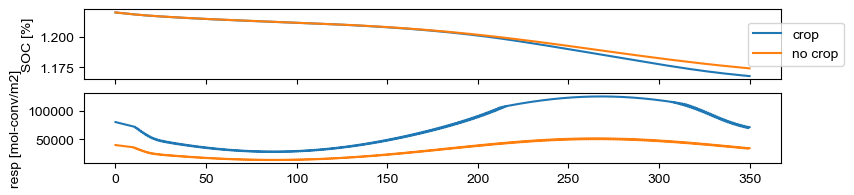

In [14]:
# ORGANIC CARBON and RESPIRATION
CO2_atm = pyEW.CO2_atm(conv_mol)

#initial pCO2
CO2_air_in = 3*CO2_atm # CO2 in soil air [mol-conv/l] 
CO2_air_in_nocrop = 2*CO2_atm # [mol-conv/l] 
ratio_aut_het = ((CO2_air_in-CO2_atm)/(CO2_air_in_nocrop-CO2_atm)-1)/(v[0]/k_v) 

#Initial organic carbon
ADD = 0 # added dry litter [gOC/(m2*d)]
SOC_in = rho_bulk*1.22/100 #[gOC/m3] 

#SOC balance and respiration
[SOC, r_het, r_aut, D] = pyEW.respiration(ADD, SOC_in, CO2_air_in, ratio_aut_het, soil, s, v, k_v, Zr, temp_soil,dt,conv_mol)
[SOC_nocrop, r_het_nocrop, r_aut_nocrop, D_nocrop] = pyEW.respiration(ADD, SOC_in, CO2_air_in_nocrop, ratio_aut_het, soil, s_nocrop, v_nocrop, k_v, Zr, temp_soil,dt,conv_mol)

# Create a figure and subplots
fig, axs = plt.subplots(2, 1,figsize=(9, 2))

# Plot the quantities in each subplot

axs[0].plot(t,100*SOC/(rho_bulk),label='crop')
axs[0].plot(t,100*SOC_nocrop/(rho_bulk),label='no crop')
axs[0].set_xticklabels([])
axs[0].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
axs[0].set_ylabel('SOC [%]')

axs[1].plot(t, r_het + r_aut)
axs[1].plot(t, r_het_nocrop + r_aut_nocrop)
axs[1].set_ylabel('resp [mol-conv/m2]')

# Display the combined graph
plt.show()

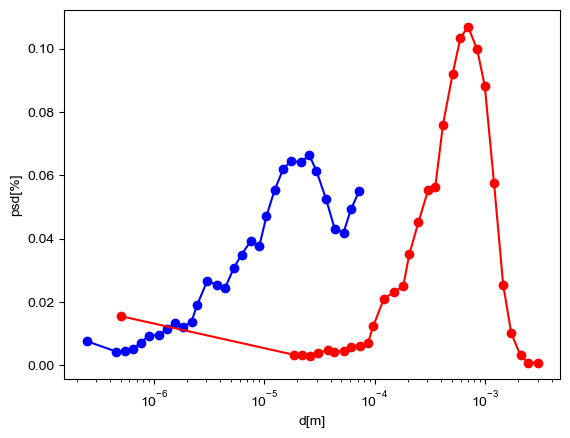

In [15]:
#fine
fine_dataset = next(dataset for dataset in data_exp_psd["datasetColl"] if dataset["name"] == "fine")
d_in_fine = [point['value'][0] for point in fine_dataset['data']]
psd_in_fine = [point['value'][1] for point in fine_dataset['data']]

#coar
coar_dataset = next(dataset for dataset in data_exp_psd["datasetColl"] if dataset["name"] == "coar")
d_in_coar = [point['value'][0] for point in coar_dataset['data']]
psd_in_coar = [point['value'][1] for point in coar_dataset['data']]

d_in_fine = np.array(d_in_fine)*1e-6 #[m]
d_in_coar = np.array(d_in_coar)*1e-6 #[m]
psd_in_fine = np.array(psd_in_fine/np.sum(psd_in_fine)) #[-] 
psd_in_coar = np.array(psd_in_coar/np.sum(psd_in_coar)) #[-]

plt.plot(d_in_fine, psd_in_fine, marker='o', color='blue', label = 'fine')
plt.plot(d_in_coar, psd_in_coar, marker='o', color='red', label = 'coar')
plt.xscale('log')
plt.xlabel('d[m]')
plt.ylabel('psd[%]')
plt.show()

In [16]:
# SOIL BIOGEOCHEMISTRY

#initial pH
pH_in = 7

#CEC 
CEC_tot = 8.6 # [mmol_c / 100 g dry-soil] 
CEC_tot = CEC_tot*1e-5*rho_bulk*Zr*conv_mol # [mol_c] 

#CEC fractions
f_Ca_in = 0.87-(0.005)
f_Mg_in = 0.05
f_K_in = 0.05
f_Na_in = 0.03
f_Al_in = 0.002
f_H_in = 0.003

f_CEC_in = np.array([f_Ca_in, f_Mg_in, f_K_in, f_Na_in, f_Al_in, f_H_in]) 
if abs(sum(f_CEC_in)-1) > 1e-3:
    raise ValueError("Sum of fractions must be 1")
    
#carbonates
CaCO3_in = 0 
MgCO3_in = 0

#measured conc water
Mg_in = 1500 # [micromol/l]
Si_in = 150 # [micromol/l]

#estimated conc water
[conc_in, K_CEC] = pyEW.Amann(f_CEC_in, pH_in, Mg_in, soil, conv_mol,conv_Al)

#Rock characteristics
M_rock_in = 22000 # [g/m2] of added rock powder
mineral = ["forsterite"] 
rock_f_in = np.array([0.9*0.92])
t_app = 0 # day of application

# Coarse Olivine Application
diss_f = 0.3 #dissolution factor
d_in = d_in_coar # [m]: diameter classes
psd_perc_in = psd_in_coar # diameter class weight (%)
SSA_in = 1.1 # [m2/g]: measured ssa
data_coar = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)
data_coar_nocrop = pyEW.biogeochem_balance(n, s_nocrop, L_nocrop, T_nocrop, I, v_nocrop, k_v, RAI, root_d, Zr, r_het_nocrop, r_aut_nocrop, D_nocrop, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# Fine Olivine Application
diss_f = 0.2 #dissolution factor
d_in = d_in_fine # [m]: diameter classes
psd_perc_in = psd_in_fine # d-class fraction of total mass
SSA_in = 9.5 # # [m2/g]: measured ssa
data_fine = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)
data_fine_nocrop = pyEW.biogeochem_balance(n, s_nocrop, L_nocrop, T_nocrop, I, v_nocrop, k_v, RAI, root_d, Zr, r_het_nocrop, r_aut_nocrop, D_nocrop, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# NO Weathering Application
M_rock_in = 0
data_untr = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)
data_untr_nocrop = pyEW.biogeochem_balance(n, s_nocrop, L_nocrop, T_nocrop, I, v_nocrop, k_v, RAI, root_d, Zr, r_het_nocrop, r_aut_nocrop, D_nocrop, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

C:\Users\Utente\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [17]:
# CO2 sequestration

#numerical
# potential due Mg released [g / (m2 yr) = (tonn/km2 yr)]
def pot_gCO2_yr(data_rock):
    gCO2=(365/t_end)*1.25*(data_rock[0]-data_rock[-1]) 
    return gCO2

pot_gCO2 = [pot_gCO2_yr(data_fine['M_rock']), pot_gCO2_yr(data_coar['M_rock'])]
pot_gCO2_nocrop = [pot_gCO2_yr(data_fine_nocrop['M_rock']), pot_gCO2_yr(data_coar_nocrop['M_rock'])]

# mol Mg in leachate
def mol_Mg_L(data_Mg,data_Mg_untr,Leaching):
    Mg_L=(365/t_end)*np.trapz((data_Mg-data_Mg_untr)*1000*Leaching/conv_mol,t) # [mol_Mg /yr m2]
    return Mg_L

# effective due to Mg in leachate
ACEM = 2 #molC/molMg (Alkalinization Carbon capture Efficiency Mineral)
gCO2_Mg_L = 44*ACEM*np.array([mol_Mg_L(data_fine['Mg'],data_untr['Mg'],L),mol_Mg_L(data_coar['Mg'],data_untr['Mg'],L)]) 
gCO2_Mg_L_nocrop = 44*ACEM*np.array([mol_Mg_L(data_fine_nocrop['Mg'],data_untr_nocrop['Mg'],L_nocrop),mol_Mg_L(data_coar_nocrop['Mg'],data_untr_nocrop['Mg'],L_nocrop)])

#experimental, effective
Delta_Mg_L_yr_fine_exp = 4.9*(1.8/(1.25*24*0.85)) # [mol_Mg /yr m2]
Delta_Mg_L_yr_coar_exp = 2.3*(1.8/(1.25*24*0.85))
gCO2_Mg_L_exp = 44*ACEM*np.array([Delta_Mg_L_yr_fine_exp,Delta_Mg_L_yr_coar_exp])

In [20]:
#pH data

# experimental pH
all_x_values_pH = []
all_y_values_pH_surf = []
all_sigma_values_pH_surf = []
all_minus_sigma_values_pH_surf = []
all_y_values_pH_deep = []
all_sigma_values_pH_deep = []
all_minus_sigma_values_pH_deep = []
series_names_pH = []

#surface
for dataset in data_exp_pH_surf['datasetColl']:
    group_0_data = [entry for entry in dataset['data'] if entry['group'] == 0]
    group_1_data = [entry for entry in dataset['data'] if entry['group'] == 1]
    group_2_data = [entry for entry in dataset['data'] if entry['group'] == 2]
    x_values_pH = [d['value'][0] for d in group_0_data]
    y_values_pH = [d['value'][1] for d in group_0_data]
    sigma_values_pH = np.array([d['value'][1] for d in group_1_data])-np.array(y_values_pH)
    minus_sigma_values_pH = np.array(y_values_pH)-np.array([d['value'][1] for d in group_2_data])
    series_names_pH = [entry['name'] for entry in data_exp_pH_surf['datasetColl']]
    all_x_values_pH.append(x_values_pH)
    all_y_values_pH_surf.append(y_values_pH)
    all_sigma_values_pH_surf.append(sigma_values_pH)
    all_minus_sigma_values_pH_surf.append(minus_sigma_values_pH)

#bottom
for dataset in data_exp_pH_deep['datasetColl']:
    group_0_data = [entry for entry in dataset['data'] if entry['group'] == 0]
    group_1_data = [entry for entry in dataset['data'] if entry['group'] == 1]
    group_2_data = [entry for entry in dataset['data'] if entry['group'] == 2]
    y_values_pH = [d['value'][1] for d in group_0_data]
    sigma_values_pH = np.array([d['value'][1] for d in group_1_data])-np.array(y_values_pH)
    minus_sigma_values_pH = np.array(y_values_pH)-np.array([d['value'][1] for d in group_2_data])
    all_y_values_pH_deep.append(y_values_pH)
    all_sigma_values_pH_deep.append(sigma_values_pH)
    all_minus_sigma_values_pH_deep.append(minus_sigma_values_pH)

#average
all_y_values_pH = [
    [(surf + deep) / 2 for surf, deep in zip(surf_list, deep_list)]
    for surf_list, deep_list in zip(all_y_values_pH_surf, all_y_values_pH_deep)
]

#standard devation
all_sigma_values_pH = [
    [np.sqrt(deep**2 + surf**2) for deep, surf in zip(deep_list, surf_list)]
    for deep_list, surf_list in zip(all_sigma_values_pH_deep, all_sigma_values_pH_surf)
]

In [21]:
#pCO2 data

#numerical pCO2
t_in_w = int(0/dt)
t_end_w = int(100/dt)
t_in_s = int(100/dt)
t_end_s = int(200/dt)

def stats(t_in, t_end, data):
    avg = np.mean(data[t_in:t_end])
    std = np.mean(data[t_in:t_end])
    return avg, std

datasets = [
    (t_in_w, t_end_w, data_coar_nocrop['CO2_air']),
    (t_in_w, t_end_w, data_untr_nocrop['CO2_air']),
    (t_in_w, t_end_w, data_coar['CO2_air']),
    (t_in_w, t_end_w, data_untr['CO2_air']),
    (t_in_s, t_end_s, data_coar_nocrop['CO2_air']),
    (t_in_s, t_end_s, data_untr_nocrop['CO2_air']),
    (t_in_s, t_end_s, data_coar['CO2_air']),
    (t_in_s, t_end_s, data_untr['CO2_air'])
]

avgs_num = []
sigma_num = []
minus_sigma_num = []

for dataset in datasets:
    avg, std = stats(*dataset)
    avgs_num.append(22.41 * avg)
    sigma_num.append(22.41 * (avg + std))
    minus_sigma_num.append(22.41 * (avg - std))
    
CO2_matm = 412 # [microatm]

# Extract data for plotting
names = data_pCO2['name']
avgs = [avgs_num, data_pCO2['5cm_avg'], data_pCO2['10cm_avg'], data_pCO2['20cm_avg']]
sigmas = [sigma_num, data_pCO2['5cm_sigma'], data_pCO2['10cm_sigma'], data_pCO2['20cm_sigma']]
minus_sigmas = [minus_sigma_num, data_pCO2['5cm_minus_sigma'], data_pCO2['10cm_minus_sigma'], data_pCO2['20cm_minus_sigma']]


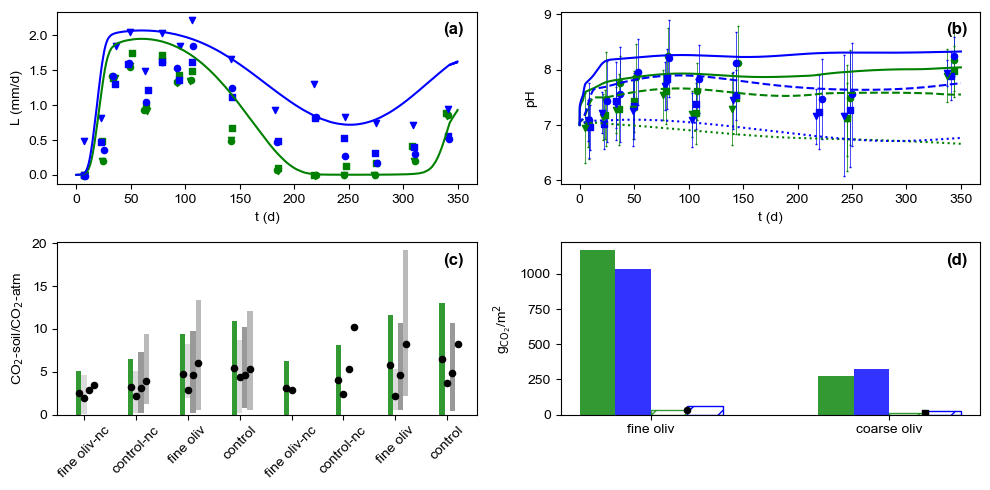

In [23]:
#Figure
fig, axs = plt.subplots(2,2,figsize=(10, 5))

custom_colors_L = ['Green','Green', 'Green', 'Blue', 'Blue', 'Blue',]
markers=['o','s','v','o','s','v']

#-------------------------------------------------------------------
# LEACHING 
#-------------------------------------------------------------------

#experimental
for i in range(len(series_names_L)):
    #axs[0,0].plot(all_x_values_L[i], all_y_values_L[i], color=custom_colors_L[i], label=series_names_L[i], linestyle=':', marker = markers[i], markersize=3, markerfacecolor=custom_colors_L[i], zorder=2)
     axs[0,0].scatter(all_x_values_L[i], all_y_values_L[i], color=custom_colors_L[i], 
                      label=series_names_L[i], marker = markers[i], s=20, zorder=2)

#numerical
axs[0,0].plot(t,L_mov_avg*1000, color='green', label ='L',zorder=3)
axs[0,0].plot(t,L_nocrop_mov_avg*1000, color='blue', label ='L_nocrop',zorder=3)

#labels
#axs[0,0].legend()
axs[0,0].set_xlabel('t (d)', fontsize=10)
axs[0,0].set_ylabel('L (mm/d)', fontsize=10)

#-------------------------------------------------------------------
# pH 
#-------------------------------------------------------------------

custom_colors_pH = ['Green','Blue', 'Green', 'Blue', 'Green', 'Blue']
markers_pH=['o','o','s','s','v','v']
#experimental
for i in range(len(series_names_pH)):
    axs[0,1].scatter(all_x_values_pH[i], all_y_values_pH[i], label=series_names_pH[i],
                     marker=markers_pH[i], color=custom_colors_pH[i], s=20, zorder=2)
    axs[0,1].errorbar(all_x_values_pH[i], all_y_values_pH[i], yerr=(all_sigma_values_pH[i],all_sigma_values_pH[i]),
                      color=custom_colors_pH[i], fmt='none', capsize=1, zorder=1,elinewidth=0.5)

#numerical
win_size = int(3/dt) #moving average time interval
axs[0,1].plot(t,pyEW.mov_avg(data_fine['pH'],win_size),label = 'fine', color = 'green',zorder=3)
axs[0,1].plot(t,pyEW.mov_avg(data_fine_nocrop['pH'],win_size),label = 'fine_nocrop', color = 'blue',zorder=3)
axs[0,1].plot(t,pyEW.mov_avg(data_coar['pH'],win_size),label = 'coar', linestyle='--', color = 'green',zorder=3)
axs[0,1].plot(t,pyEW.mov_avg(data_coar_nocrop['pH'],win_size),label = 'coar_nocrop', linestyle='--', color = 'blue',zorder=3)
axs[0,1].plot(t,pyEW.mov_avg(data_untr['pH'],win_size), label = 'untr', linestyle=':', color = 'green',zorder=3)
axs[0,1].plot(t,pyEW.mov_avg(data_untr_nocrop['pH'],win_size), label = 'untr_nocrop', linestyle=':', color = 'blue',zorder=3)

#labels
axs[0,1].set_xlabel('t (d)', fontsize=10)
axs[0,1].set_ylabel('pH', fontsize=10)

#-------------------------------------------------------------------
# pCO2
#-------------------------------------------------------------------

# Plot the bars and circles
bar_width = 0.1
bar_positions = np.arange(len(names))
custom_colors_pCO2 = ['green', 'lightgray', 'gray', 'darkgray']
markers_pCO2 = ['o','o','o','o']

for i in range(len(avgs)):
    range_values = [(sigma - minus_sigma)/CO2_matm for sigma, minus_sigma in zip(sigmas[i], minus_sigmas[i])]
    axs[1,0].scatter(bar_positions + i * bar_width, np.array(avgs[i])/CO2_matm, marker=markers_pCO2[i], 
                     color='black', s=20, zorder=3)
    axs[1,0].bar(bar_positions + i * bar_width, range_values, bottom=np.array(minus_sigmas[i])/CO2_matm, width=bar_width,
           align='center', color=custom_colors_pCO2[i], alpha=0.8)
        
# Set labels and title
orange_patch = plt.Rectangle((0, 0), 1, 1, fc="green")
orange_patch2 = plt.Rectangle((0, 0), 1, 1, fc="blue")
blue_patch = plt.Rectangle((0, 0), 1, 1, fc="lightgray")
red_patch = plt.Rectangle((0, 0), 1, 1, fc="gray")
green_patch = plt.Rectangle((0, 0), 1, 1, fc="darkgray")
axs[1,0].set_ylabel('CO$_2$-soil/CO$_2$-atm')
axs[1,0].set_xticks(bar_positions + bar_width)
names = ['fine oliv-nc','control-nc', 'fine oliv', 'control', 'fine oliv-nc','control-nc', 'fine oliv', 'control']
axs[1,0].set_xticklabels(names,rotation=45)
#axs[1,0].legend([orange_patch,orange_patch2,blue_patch, red_patch, green_patch], ['model','model-nocrop','exp 5cm', 'exp 10cm', 'exp 20cm'])

#-------------------------------------------------------------------
# Sequestered CO2
#-------------------------------------------------------------------
categories = ['fine oliv','coarse oliv']
custom_colors = ['green','blue']
bar_width = 0.15
x_pos = np.arange(len(categories))

#numerical
axs[1,1].bar(x_pos, pot_gCO2, width=bar_width, align='center', alpha=0.8, color='green', label = 'potential')
axs[1,1].bar(x_pos + bar_width, pot_gCO2_nocrop, width=bar_width, align='center', alpha=0.8, color='blue', label = 'potential -nocrop')
axs[1,1].bar(x_pos + 2*bar_width, gCO2_Mg_L, width=bar_width, align='center', hatch='/', edgecolor='green', alpha=0.8, color='white', label = 'Mg')
axs[1,1].bar(x_pos + 3*bar_width, gCO2_Mg_L_nocrop, width=bar_width, align='center', hatch='/', edgecolor='blue',fill=False, label = 'Mg - nocrop')

#experimental
axs[1,1].scatter(0 + 2.5*bar_width, gCO2_Mg_L_exp[0], marker='o', s=20, color='black')
axs[1,1].scatter(1 + 2.5*bar_width, gCO2_Mg_L_exp[1], marker='s', s=20, color='black')

axs[1,1].set_xticks(x_pos + 1.5*bar_width, categories)
axs[1,1].set_ylabel('g$_{\mathrm{CO}_2}$/m$^2$')

#-------------------------------------------------------------------
#plot labels
axs[0, 0].text(0.92, 0.87, '(a)', transform=axs[0, 0].transAxes, fontsize=12, fontweight='bold')
axs[0, 1].text(0.92, 0.87, '(b)', transform=axs[0, 1].transAxes, fontsize=12, fontweight='bold')
axs[1, 0].text(0.92, 0.87, '(c)', transform=axs[1, 0].transAxes, fontsize=12, fontweight='bold')
axs[1, 1].text(0.92, 0.87, '(d)', transform=axs[1, 1].transAxes, fontsize=12, fontweight='bold')

#plot
plt.tight_layout()
plt.show()